In [1]:
import pandas as pd
import numpy as np
import re    
import nltk
import string
import spacy
from sklearn.preprocessing import normalize
from scipy.spatial import distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [2]:
#read conbined info from each bar
#f indicates the first csv file, end-1 indicates last csv file
def read_reviews(f,end):
    rere=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Archive/"+name+".csv",header=0)
        gg=data["Description"].copy()
        gg=pre_remove(gg)
        for j in gg:
            rere.append(j)
    return rere

def read_rating(f,end):
    rating=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Archive/"+name+".csv",header=0)
        rr=data["Reting"].copy()
        for j in rr:
            rating.append(j)
    return rating

def read_label(f,end):
    label_senti=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Archive/"+name+".csv",header=0)
        rr=data["label"].copy()
        for j in rr:
            label_senti.append(j)
    return label_senti

In this section, we tokenized the reviews from each wine bar, including turning the text to lower case and removing the emojis in the text.
Remove the punctuations and stopwords then lemmatization the words.

In [3]:
#tokenize and prepare for the reviews
def tokenize(reviews):
    
    bigrams=[]
    for i in range(len(reviews)):
        #turn the text to lower case
        reviews[i]=reviews[i].lower()

        #remove emoji in the text
        RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
        reviews[i] = RE_EMOJI.sub(r'', reviews[i])

        #tokenize the text
        reviews[i]= nltk.word_tokenize(reviews[i])

        #remove the punctuations
        reviews[i]=[token.strip(string.punctuation) for token in reviews[i]]

        #remove the stopword
        reviews[i]=[token for token in reviews[i] if token not in stop_words]
        
        #remove the empty tokens
        reviews[i]=[token.strip() for token in reviews[i] if token.strip()!='']

        ##Lemmatization
        for j in range(len(reviews[i])):        
            reviews[i][j]=lemmatizer.lemmatize(reviews[i][j])
            
        #form bigrams
        bigrams.append(list(nltk.bigrams(reviews[i])))
        
    return reviews

def pre_remove(reviews):
    for i in range(len(reviews)):
        #turn the text to lower case
        reviews[i]=reviews[i].lower()

        #remove emoji in the text
        RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
        reviews[i] = RE_EMOJI.sub(r'', reviews[i])
        
    return reviews

In [4]:
#Create tf-idf matrix
def to_matrix(x):
    docs_tokens={idx:nltk.FreqDist(doc) for idx,doc in enumerate(x)}
        #convert dictionary to matrix
    dtm=pd.DataFrame.from_dict(docs_tokens,orient="index" )
    dtm=dtm.fillna(0)
        # get term frequency matrix
    tf=dtm.values
    doc_len=tf.sum(axis=1) 
    tf=np.divide(tf, doc_len[:,None])
        # get Inverse Document Frequency
    df=np.where(tf>0,1,0)
    idf=np.log(np.divide(len(x)+1,  np.sum(df, axis=0)+1))+1
        # get tf-idf
    tf_idf=normalize(tf*idf)
    return tf_idf


We performed simple naive sentiment analysis for each store to get the sentiment of the reviews
The positive and negative dictionary are provided by class materials.

In [7]:
#Naive sentiment analysis 
with open("/Users/jason/Documents/BIA study/Web Mining/Final Project/positive-words.txt",'r') as f:
    positive_words=[line.strip() for line in f]
with open("/Users/jason/Documents/BIA study/Web Mining/Final Project/negative-words.txt",'r') as f:
    negative_words=[line.strip() for line in f]
negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
positive_count=[]
negative_count=[]

rere=read_reviews(1,5)
reviews=tokenize(rere)
for i in range(len(reviews)):
    
    #count the positive words
    positive_tokens=[]
    for idx, token in enumerate(reviews[i]):
        if token in positive_words:
            if idx>0:
                if reviews[i][idx-1] not in negations:
                    positive_tokens.append(token)
            else:
                positive_tokens.append(token)
    positive_count.append(len(positive_tokens))
    
    #count the negative words
    negative_tokens=[]
    for idx, token in enumerate(reviews[i]):
        if token in negative_words:
            if idx>0:
                if reviews[i][idx-1] not in negations:
                    negative_tokens.append(token)
            else:
                negative_tokens.append(token)
    negative_count.append(len(negative_tokens)) 
     
# majority vote
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append("negative")   
    elif negative_count[i] < positive_count[i]:
        sentiment.append("positive")   
    else:
        sentiment.append("neutral")
        
# read the sentiment we manaully labeled     
label_senti=read_label(1,5)

#compare th result of naive sentiment analysis with labeled rating score         
pd.crosstab(pd.Series(sentiment),pd.Series(label_senti))


col_0,0,1
row_0,,
negative,29,21
neutral,41,106
positive,62,1171


In [8]:
#assign the neutral sentiment to negative 
#see the performance
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append(0)   #negative
    elif negative_count[i] < positive_count[i]:
        sentiment.append(1)   #positive
    else:
        sentiment.append(0)    #neutral
#calculate the accuracy of naive sentiment analysis 
label_senti=read_label(1,5)
auc1=accuracy_score(list(map(int, sentiment)),label_senti)
print(auc1)
print(classification_report(label_senti,sentiment, target_names=["0","1"]))
pd.crosstab(pd.Series(label_senti),pd.Series(sentiment))

0.8678321678321679
              precision    recall  f1-score   support

           0       0.36      0.53      0.43       132
           1       0.95      0.90      0.93      1298

   micro avg       0.87      0.87      0.87      1430
   macro avg       0.65      0.72      0.68      1430
weighted avg       0.89      0.87      0.88      1430



col_0,0,1
row_0,,
0,70,62
1,127,1171


In [9]:
#assign the neutral sentiment to positive 
#see the performance
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append(0)   #negative
    elif negative_count[i] < positive_count[i]:
        sentiment.append(1)   #positive
    else:
        sentiment.append(1)    #neutral
#calculate the accuracy of naive sentiment analysis 
label_senti=read_label(1,5)
auc1=accuracy_score(list(map(int, sentiment)),label_senti)
print(auc1)
print(classification_report(label_senti,sentiment, target_names=["0","1"]))
pd.crosstab(pd.Series(label_senti),pd.Series(sentiment))

0.9132867132867133
              precision    recall  f1-score   support

           0       0.58      0.22      0.32       132
           1       0.93      0.98      0.95      1298

   micro avg       0.91      0.91      0.91      1430
   macro avg       0.75      0.60      0.64      1430
weighted avg       0.89      0.91      0.90      1430



col_0,0,1
row_0,,
0,29,103
1,21,1277


In [27]:
#Accoding to the rating score, created a feature for sentiment analysis
level_rating=[]
rrating=read_rating(1,5)
for i in rrating:
    if i>4:
        level_rating.append(1)#"positive"
    elif i==4:
        level_rating.append(1)#"neutral"
    else:
        level_rating.append(0)#"negative"

auc1=accuracy_score(list(map(int, level_rating)),label_senti)
print(auc1)
print(classification_report(level_rating,label_senti, target_names=["0","1"]))
pd.crosstab(pd.Series(level_rating),pd.Series(label_senti))

0.9769230769230769
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       143
           1       0.98      0.99      0.99      1287

   micro avg       0.98      0.98      0.98      1430
   macro avg       0.95      0.92      0.93      1430
weighted avg       0.98      0.98      0.98      1430



col_0,0,1
row_0,,
0,121,22
1,11,1276


mean AUC value of cross validation: 0.8629017055940134
col_0   0    1
row_0         
0      23   13
1      44  349
              precision    recall  f1-score   support

           0       0.34      0.64      0.45        36
           1       0.96      0.89      0.92       393

   micro avg       0.87      0.87      0.87       429
   macro avg       0.65      0.76      0.69       429
weighted avg       0.91      0.87      0.88       429

accuracy_score: 0.8671328671328671
AUC value: 0.8799830364715862


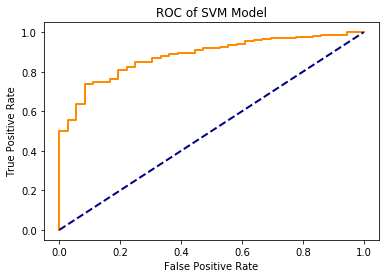

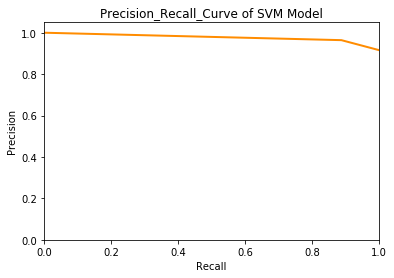

In [42]:
#perform sentiment analysis classification

rere=read_reviews(1,5) #data to build trainning model
label_senti=read_label(1,5)
#rere=tokenize(rere)
#mama=to_matrix(rere)
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=5) 
mama= tfidf_vect.fit_transform(rere)    
   
class_weights = {1:0.4,0:30}

clf2 = svm.SVC(kernel='linear', class_weight=class_weights)

metrics = ['roc_auc']
cv2 = cross_validate(clf2, mama, label_senti,scoring=metrics, cv=5,return_train_score=True)
print("mean AUC value of cross validation:",np.mean(cv2['test_roc_auc']))


X_train, X_test, y_train, y_test = train_test_split(mama,label_senti, test_size=0.3, random_state=0)

svc = svm.SVC(kernel='linear',probability=True, class_weight=class_weights)
model = svc.fit(X_train, y_train)
predicted2=model.predict(X_test)

print(pd.crosstab(pd.Series(y_test), pd.Series(predicted2)))
print(classification_report(y_test, predicted2, target_names=['0','1']))
print("accuracy_score:",accuracy_score(y_test,predicted2))

#calculate AUC
predict_p=model.predict_proba(X_test)
y_pred = predict_p[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred,pos_label=1)
print('AUC value:',auc(fpr, tpr))

#plot ROC curve
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC of SVM Model');
plt.show();

#plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,predicted2, pos_label=1)
plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of SVM Model');
plt.show();



In [98]:
#to predict the sentiment 
pp=read_reviews(8,9)   
new_tfidf = tfidf_vect.transform(pp) 
svc2 = svm.SVC(kernel='linear',probability=True, class_weight=class_weights)
model = svc2.fit(mama, label_senti)
predicted3=model.predict(new_tfidf)

In [35]:
#multi-label classification on the topic
#   $ pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB

data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Trainning_mutilabeled.csv",header=0)
dtd=pre_remove(data["Description"].copy())
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=5) 
mama2= tfidf_vect.fit_transform(dtd)
label_senti2=data[["Food","Service","Atmosphere","Price"]].copy()
classifier = BinaryRelevance(svm.LinearSVC())

X_train, X_test, y_train, y_test = train_test_split(mama2,label_senti2, test_size=0.3, random_state=0)
# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
# convert from sparse matrix to dataframe
ppp=pd.DataFrame(predictions.toarray(),columns=["Foodp","Servicep","Atmospherep","Pricep"])
y_test=pd.DataFrame(y_test.values,columns=["Food","Service","Atmosphere","Price"])

print("total-accuracy:",accuracy_score(y_test,predictions))

print(classification_report(y_test, predictions,target_names=['Food','Service','Atmosphere','Price']))

print(pd.crosstab(y_test["Food"],ppp["Foodp"]))
print("Food-accuracy:",accuracy_score(y_test["Food"],ppp["Foodp"]))

print(pd.crosstab(y_test["Service"],ppp["Servicep"]))
print("Service-accuracy:",accuracy_score(y_test["Service"],ppp["Servicep"]))

print(pd.crosstab(y_test["Atmosphere"],ppp["Atmospherep"]))
print("Atmosphere-accuracy:",accuracy_score(y_test["Atmosphere"],ppp["Atmospherep"]))

print(pd.crosstab(y_test["Price"],ppp["Pricep"]))
print("Price-accuracy:",accuracy_score(y_test["Price"],ppp["Pricep"]))

total-accuracy: 0.5913461538461539
              precision    recall  f1-score   support

        Food       0.90      0.88      0.89       275
     Service       0.85      0.68      0.76       120
  Atmosphere       0.75      0.51      0.61        82
       Price       0.55      0.27      0.36        59

   micro avg       0.85      0.71      0.77       536
   macro avg       0.76      0.59      0.65       536
weighted avg       0.83      0.71      0.76       536
 samples avg       0.63      0.58      0.59       536

Foodp    0    1
Food           
0      114   27
1       34  241
Food-accuracy: 0.8533653846153846
Servicep    0   1
Service          
0         282  14
1          38  82
Service-accuracy: 0.875
Atmospherep    0   1
Atmosphere          
0            320  14
1             40  42
Atmosphere-accuracy: 0.8701923076923077
Pricep    0   1
Price          
0       344  13
1        43  16
Price-accuracy: 0.8653846153846154


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Average precision score, micro-averaged over all classes: 0.70


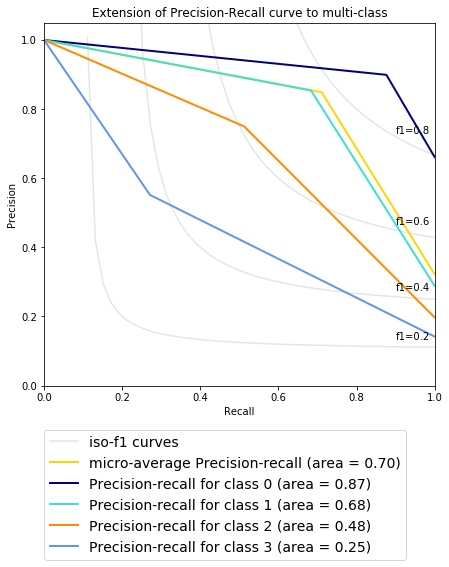

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
y_test=np.array(y_test)
ppp=np.array(ppp)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],ppp[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], ppp[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),ppp.ravel())
average_precision["micro"] = average_precision_score(y_test, ppp,average="micro")

print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
#############################################################

from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.48), prop=dict(size=14))


plt.show()

In [99]:
#to predict the topic
data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Trainning_mutilabeled.csv",header=0)
dtd=pre_remove(data["Description"].copy())
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=5) 
mama2= tfidf_vect.fit_transform(dtd)
label_senti2=data[["Food","Service","Atmosphere","Price"]].copy()
classifier = BinaryRelevance(svm.LinearSVC())
classifier.fit(mama2, label_senti2)

pp=read_reviews(8,9)   
new_tfidf2 = tfidf_vect.transform(pp) 
predictions2 = classifier.predict(new_tfidf2)
predictions2=pd.DataFrame(predictions2.toarray(),columns=["Foodp","Servicep","Atmospherep","Pricep"])

We combined the result of sentiment prediction and topic prediction

In [103]:
#Result interpret
Food=pd.crosstab(predictions2["Foodp"],predicted3).iloc[1,:]
Service=pd.crosstab(predictions2["Servicep"],predicted3).iloc[1,:]
Atmosphere=pd.crosstab(predictions2["Atmospherep"],predicted3).iloc[1,:]
Price=pd.crosstab(predictions2["Pricep"],predicted3).iloc[1,:]
result=pd.DataFrame(dict(Food=Food, Service=Service,Atmosphere=Atmosphere,Price=Price))
print("total reviews:",len(pp))
print("Food:",result.iloc[0,0]/result.iloc[1,0])
print("Service:",result.iloc[0,1]/result.iloc[1,1])
print("Atmosphere:",result.iloc[0,2]/result.iloc[1,2])
print("Price:",result.iloc[0,3]/result.iloc[1,3])
result

total reviews: 311
Food: 0.10457516339869281
Service: 0.1111111111111111
Atmosphere: 0.0
Price: 0.625


,Food,Service,Atmosphere,Price
col_0,,,,
0,16,4,0,5
1,153,36,12,8


In [47]:
#part of speech 

tagged_tokens=[]

dt_POS= read_reviews(1,2)
dt_POS=tokenize(dt_POS)
for i in dt_POS:
    tagged_tokens.append(nltk.pos_tag(i))

bigrams=list(nltk.bigrams(tagged_tokens[2]))

phrases2=[ (x[0],y[0]) for (x,y) in bigrams \
         if x[1].startswith('JJ') \
         and y[1].startswith('NN')]

phrases1=[ (x[0],y[0]) for (x,y) in bigrams \
         if x[1].startswith('NN') \
         and y[1].startswith('JJ')]

print(phrases2,phrases1)

[('great', 'host'), ('great', 'date'), ('cheese', 'chocolate')] [('robert', 'great'), ('host', 'great')]
